In [1]:
import findspark
import pyspark
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
import os
os.getcwd()

'/home/jovyan'

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [4]:
spark = SparkSession \
    .builder \
    .appName("Pysparkexample") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

In [7]:
df_load = spark.read.csv('hdfs://192.168.122.206:8020/data/vol/depart/*.csv',header='true')

In [8]:
df=df_load.orderBy('last_update_fme', ascending = False).dropDuplicates(['aircraft_aircrafttype_iatacode','timestamps_eobt','airports_next_name'])

In [9]:
df_load_meteo = spark.read.csv('hdfs://192.168.122.206:8020/data/meteo/*.csv')

In [10]:
df_load_meteo=df_load_meteo.withColumnRenamed("_c0","index").withColumnRenamed("_c1","numero").withColumnRenamed("_c2","pression").withColumnRenamed("_c3","direction_de_vent").withColumnRenamed("_c4","vitesse_de_vent").withColumnRenamed("_c5","temperature").withColumnRenamed("_c6","humidité").withColumnRenamed("_c7","visibilité").withColumnRenamed("_c8","nebulosite").withColumnRenamed("_c9","hauteur_neige").withColumnRenamed("_c10","precipitations_1").withColumnRenamed("_c11","precipitations_3").withColumnRenamed("_c12","nom").withColumnRenamed("_c13","longitude").withColumnRenamed("_c14","latitude").withColumnRenamed("_c15","timestamp") 

In [11]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:from_unixtime(x, format='yyyy-MM-dd HH:mm:ss')
df_load_meteo=df_load_meteo.withColumn('timestamp',func(df_load_meteo['timestamp']))


In [12]:
df_load_meteo=df_load_meteo.dropDuplicates(['nom','timestamp'])

In [13]:
import pyspark.sql.functions as F
df_meteo=df_load_meteo.withColumn("timestamp_30_before", df_load_meteo.timestamp - F.expr('INTERVAL 30 MINUTES') )
df_meteo=df_meteo.withColumn("timestamp_30_after", df_load_meteo.timestamp + F.expr('INTERVAL 30 MINUTES') )

In [14]:
df_Lyon_meteo=df_meteo.filter("nom = 'Arrondissement de Lyon'")

In [15]:
df_Lyon_meteo.printSchema()


root
 |-- index: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- pression: string (nullable = true)
 |-- direction_de_vent: string (nullable = true)
 |-- vitesse_de_vent: string (nullable = true)
 |-- temperature: string (nullable = true)
 |-- humidité: string (nullable = true)
 |-- visibilité: string (nullable = true)
 |-- nebulosite: string (nullable = true)
 |-- hauteur_neige: string (nullable = true)
 |-- precipitations_1: string (nullable = true)
 |-- precipitations_3: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timestamp_30_before: string (nullable = true)
 |-- timestamp_30_after: string (nullable = true)



In [16]:
joined_df = df.join(df_Lyon_meteo, [df.timestamps_eobt < df_Lyon_meteo.timestamp_30_after,df_Lyon_meteo.timestamp_30_before < df.timestamps_eobt], how='inner')

In [17]:
joined_df=joined_df.dropDuplicates(['aircraft_aircrafttype_iatacode','timestamps_eobt','airports_next_name'])

In [18]:
joined_df=joined_df.orderBy('timestamps_eobt').select(['aircraft_aircrafttype_icaocode','flightnumbers_icaoflightnumber', 'airportresources_terminal','airports_destination_name','airlines_airline_name','airlines_operator_icaocode','airlines_airline_icaocode','countrytype_code','timestamps_sobt','timestamps_eobt','pression', 'direction_de_vent',
       'vitesse_de_vent', 'temperature', 'humidité', 'visibilité',
       'nebulosite', 'hauteur_neige'])

In [19]:
def changethedate(s):
    tab=s.split("-")
    if len(tab[1])==1:
        tab[1]='0'+tab[1]
    s=tab[0]+'-'+tab[1]+'-'+tab[2]
    return s
import json
import requests
import time
import pandas as pd
url="https://pomber.github.io/covid19/timeseries.json"
            #print(url)
response = requests.get(url)
data_json=response.json()

dd=[]
for d in data_json:
        for l in data_json[d]:
                l['pays']=d
                dd.append(l)

covid_df= spark.createDataFrame(dd)
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
func =  udf (lambda x: changethedate(x),StringType())
covid_df=covid_df.withColumn('new_date',func(covid_df['date']))
from pyspark.sql.types import DateType
func =  udf (lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'),DateType())
covid_df=covid_df.withColumn('date_obs',func(covid_df['new_date']))

#create data frame
covid_df=covid_df.select('pays','date_obs','confirmed')

In [20]:
covid_df=covid_df.filter(F.col('pays')=='France')

In [21]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:pyspark.sql.functions.split(x, ' ')
joined_df=joined_df.withColumn('datedepart',func(joined_df['timestamps_sobt']).getItem(0))

In [22]:
df_Glob = joined_df.join(covid_df, [joined_df.datedepart==covid_df.date_obs], how='left')

In [23]:
from pyspark.sql.functions import coalesce
df_Glob=df_Glob.withColumn('date_obs', coalesce('date_obs', 'datedepart'))
df_Glob=df_Glob.na.fill({'pays': 'France', 'confirmed': 0})

In [23]:
from pyspark.sql.functions import isnan, when, count, col

df_Glob.select([count(when(isnan(c), c)).alias(c) for c in df_Glob.columns]).show()

KeyboardInterrupt: 

In [24]:
df_Avis= spark.read.csv('hdfs://192.168.122.206:8020/data/outF.csv',header='true')

In [25]:
df_Avis.show()

+---+---------+------------------+------------------+-------------------+
|_c0|  airline|          nbetoile|          negative|           positive|
+---+---------+------------------+------------------+-------------------+
|  0|      TUI| 3.388118811881188|0.7069306930693069|0.29306930693069305|
|  1| Aeroflot|2.7745019920318725|0.6326693227091633| 0.3673306772908366|
|  2|   Lingus|3.4017699115044246|0.7911504424778761| 0.2088495575221239|
|  3| Emirates|3.6652694610778442|0.6976047904191617| 0.3023952095808383|
|  4|     Alba| 3.052325581395349|0.7093023255813954|0.29069767441860467|
|  5|airfrance|3.2318840579710146|0.6405797101449275|0.35942028985507246|
|  6|Eurowings|2.1142857142857143|0.5714285714285714|0.42857142857142855|
|  7|  Nostrum| 3.493333333333333|              0.64|               0.36|
|  8|      KLM| 3.562732919254658|0.6807453416149069|0.31925465838509315|
|  9|  EasyJet|3.4254980079681276|0.6900398406374502| 0.3099601593625498|
| 10|  Vueling| 2.310756972111554|0.68

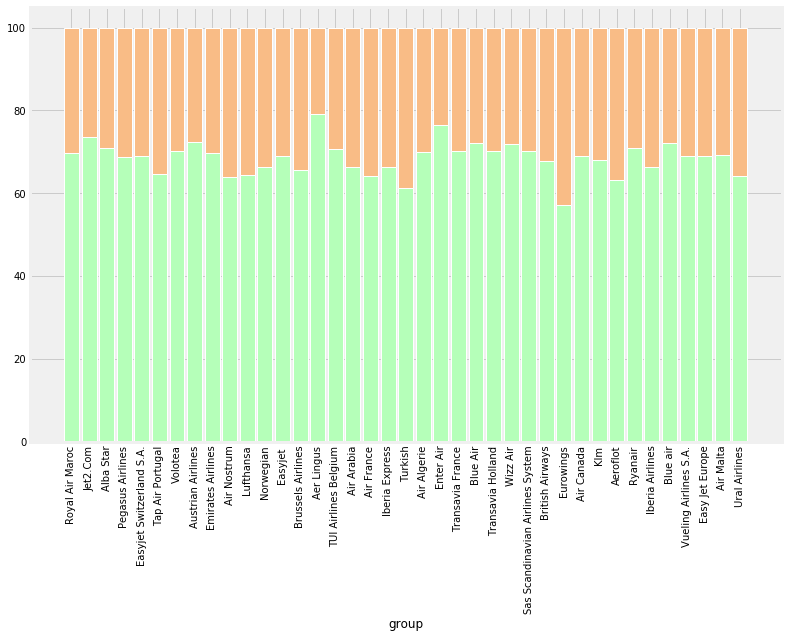

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data

r = [0,1,2,3,4]
# From raw value to percentage
totals = [float(i)+float(j) for i,j in zip(df_n['negative'], df_n['positive'])]
greenBars = [float(i) / j * 100 for i,j in zip(df_n['negative'], totals)]
orangeBars = [float(i) / j * 100 for i,j in zip(df_n['positive'], totals)]
plt.figure(figsize=(12,8))
# plot
barWidth = 0.85
names = df_n["airlines_airline_name"].values.tolist()
# Create green Bars
plt.bar(names, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(names, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)

# Custom x axis
plt.xticks(rotation=90)
plt.xticks( names)
plt.xlabel("group")

# Show graphic
plt.show()


In [159]:
mvv_list =df_Glob.select("airlines_airline_name").collect()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43699)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:43699)

In [27]:
mvv_array = set([row.airlines_airline_name for row in mvv_list])

In [160]:
mvv_array

{'A SUPPRIMER',
 'A supprimer',
 'AIRHORIZONT',
 'ASL Airlines France',
 'Aer Lingus',
 'Aeroflot',
 'Air Algerie',
 'Air Arabia',
 'Air Armenia',
 'Air Cairo Ltd',
 'Air Canada',
 'Air Europa',
 'Air France',
 'Air Malta',
 'Air Nostrum',
 'Air corsica',
 'Alba Star',
 'Almasria universal airlines',
 'Austrian Airlines',
 'BLA',
 'BLX',
 'Blue Air',
 'Blue air',
 'Boliviana de Aviacion (BoA)',
 'Braathens Regional Aviation AB',
 'British Airways',
 'Brussels Airlines',
 'Chalair Aviation',
 'Easy Jet Europe',
 'Easyjet ',
 'Easyjet Switzerland S.A.',
 'Emirates Airlines',
 'Enter Air',
 'Eurowings',
 'FLY EGYPT',
 'FLY GR8',
 'Finnair',
 'Flybe',
 'Free Bird Airlines',
 'Free bird europe',
 'GET JET Airlines',
 'Iberia Airlines',
 'Iberia Express',
 'Jet2.Com',
 'Klm',
 'Lufthansa',
 'Monarch Airlines',
 'NILE AIR',
 'Norwegian',
 'Nouvelair',
 'Onur Air Tasimacilik',
 'PVT airline FARMS',
 'Pegasus Airlines',
 'Pichard Executve',
 'RBG',
 'RLU',
 'Royal Air Maroc',
 'Ryanair',
 'Sas 

In [29]:
mvv_list2 =df_Avis.select("airline").collect()

In [30]:
mvv_array2 = set([row.airline for row in mvv_list2])

In [31]:
s=[]
s.append(('Royal Air Maroc','RAMAROC'))
s.append(('Jet2.Com','Jet2com'))
for a in mvv_array:
    for b in mvv_array2:
        if(b.lower() in a.lower()or b.lower() in a.replace(" ", "").lower() ):
            s.append((a,b))

        

In [32]:
dict1=df_Avis.select("airline","nbetoile","negative","positive").toPandas().set_index('airline').T.to_dict('list')

In [33]:
t=[]
for i in range(0,len(s)):
    t.append((s[i][0],dict1[s[i][1]][0],dict1[s[i][1]][1],dict1[s[i][1]][2]))
    

In [34]:
df_n=pd.DataFrame(t, columns =['airlines_airline_name', 'nbetoile', 'negative','positive']) 

In [35]:
df_n

,airlines_airline_name,nbetoile,negative,positive
0,Royal Air Maroc,2.43655489809336,0.6969099276791585,0.30309007232084156
1,Jet2.Com,4.4199203187251,0.7362549800796813,0.26374501992031874
2,Alba Star,3.052325581395349,0.7093023255813954,0.29069767441860467
3,Pegasus Airlines,2.790438247011952,0.6884462151394423,0.3115537848605578
4,Easyjet Switzerland S.A.,3.4254980079681276,0.6900398406374502,0.3099601593625498
5,Tap Air Portugal,2.8247011952191237,0.6454183266932271,0.3545816733067729
6,Volotea,2.555378486055777,0.7019920318725099,0.29800796812749003
7,Austrian Airlines,3.4932270916334662,0.7235059760956175,0.2764940239043825
8,Emirates Airlines,3.6652694610778442,0.6976047904191617,0.3023952095808383
9,Air Nostrum,3.493333333333333,0.64,0.36


In [36]:
def to_part_of_day(x):
    if x < 12:
        return "morning"
    elif x < 18:
        return "afternoon"
    else:
        return "evening"
def change(row):
    row['part_of_day']=to_part_of_day(row['timestamps_sobt'].hour)
    if((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60 > 0):
        row['delay']=int((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60)
    else :
        row['delay']=0
    if(int(row['delay'])<=15):
        row['delayLabel']='[0-15]'
    elif(15<int(row['delay'])<=30) :
        row['delayLabel']='[15-30]'
    elif(30<int(row['delay'])<=45) :
        row['delayLabel']='[30-45]'
    elif(45<int(row['delay'])<=60) :
        row['delayLabel']='[45-60]'
    elif(60<int(row['delay'])<=75) :
        row['delayLabel']='[60-75]'
    elif(75<int(row['delay'])<=90) :
        row['delayLabel']='[75-90]'
    elif(90<int(row['delay'])<=150) :
        row['delayLabel']='[90-150]'
    elif(150<int(row['delay'])<=210) :
        row['delayLabel']='[150-210]'
    elif(210<int(row['delay'])<=270) :
        row['delayLabel']='[210-270]'
    elif(270<int(row['delay'])<=300) :
        row['delayLabel']='[270-300]'
    else:
        row['delayLabel']='more then 5 hours'
    
    return row
            

In [37]:
pdf=df_Glob.toPandas()

In [38]:
pdf=pdf.merge( df_n,how='left', on = 'airlines_airline_name')

In [39]:
pdf

,aircraft_aircrafttype_icaocode,flightnumbers_icaoflightnumber,airportresources_terminal,airports_destination_name,airlines_airline_name,airlines_operator_icaocode,airlines_airline_icaocode,countrytype_code,timestamps_sobt,timestamps_eobt,pression,direction_de_vent,vitesse_de_vent,temperature,humidité,visibilité,nebulosite,hauteur_neige,datedepart,pays,date_obs,confirmed,nbetoile,negative,positive
0,A320,EJU4459,T1,Tenerife,Easy Jet Europe,EJU,EJU,S,2020-02-26 14:00:00,2020-02-26 14:00:00,101100,310,10.8,279.68,45,10000,75,0.0,2020-02-26,France,2020-02-26,18,3.4254980079681276,0.6900398406374502,0.3099601593625498
1,B737,KLM1416,T2,Amsterdam,Klm,KLM,KLM,S,2020-02-26 14:10:00,2020-02-26 14:10:00,101100,310,10.8,279.68,45,10000,75,0.0,2020-02-26,France,2020-02-26,18,3.562732919254658,0.6807453416149069,0.31925465838509315
2,A320,EJU4353,T1,Nantes,Easy Jet Europe,EJU,EJU,N,2020-02-26 14:10:00,2020-02-26 14:12:00,101100,310,10.8,279.68,45,10000,75,0.0,2020-02-26,France,2020-02-26,18,3.4254980079681276,0.6900398406374502,0.3099601593625498
3,A319,EJU4371,T1,Berlin-Schonefeld,Easy Jet Europe,EJU,EJU,S,2020-02-26 14:15:00,2020-02-26 14:15:00,101100,310,10.8,279.68,45,10000,75,0.0,2020-02-26,France,2020-02-26,18,3.4254980079681276,0.6900398406374502,0.3099601593625498
4,A320,AFR7643,T2,Paris C. De Gaulle,Air France,AFR,AFR,N,2020-02-26 14:15:00,2020-02-26 14:32:00,101200,300,9.3,279.75,42,10000,75,0.0,2020-02-26,France,2020-02-26,18,3.2318840579710146,0.6405797101449275,0.35942028985507246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17473,AT45,CLG076,T2,Limoges,Chalair Aviation,CLG,CLG,N,2020-04-05 20:10:00,2020-04-05 20:10:00,101900,170,4.6,286.2,38,10000,0,0.0,2020-04-05,France,2020-04-05,71412,NaN,NaN,NaN
17474,B738,DAH1139,T1,Bejaia,Air Algerie,DAH,DAH,I,2020-05-01 12:50:00,2020-05-01 12:50:00,100800,209,2.25,284.77,95,0,100,0.0,2020-05-01,France,2020-05-01,167305,2.73972602739726,0.6986301369863014,0.3013698630136986
17475,B748,DAH1037,T1,Alger,Air Algerie,DAH,DAH,I,2020-05-01 13:35:00,2020-05-01 13:35:00,100800,209,2.25,284.77,95,0,100,0.0,2020-05-01,France,2020-05-01,167305,2.73972602739726,0.6986301369863014,0.3013698630136986
17476,B738,DAH1461,T1,Constantine,Air Algerie,DAH,DAH,I,2020-05-01 18:20:00,2020-05-01 18:20:00,100800,270,3.24,285.39,95,0,100,0.0,2020-05-01,France,2020-05-01,167305,2.73972602739726,0.6986301369863014,0.3013698630136986


In [40]:
from datetime import datetime
pdf['timestamps_eobt'] = pdf['timestamps_eobt'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
pdf['timestamps_sobt'] =pdf['timestamps_sobt'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
pdf=pdf.apply(lambda x:change(x),axis=1)

In [41]:
pdf=pdf.astype({'pression': 'float64'})
pdf=pdf.astype({'direction_de_vent': 'float64'})
pdf=pdf.astype({'vitesse_de_vent': 'float64'})

pdf=pdf.astype({'temperature': 'float64'})
pdf=pdf.astype({'humidité': 'float64'})
pdf=pdf.astype({'visibilité': 'float64'})
pdf=pdf.astype({'hauteur_neige': 'float64'})
pdf=pdf.astype({'nebulosite': 'float64'})
pdf=pdf.astype({'confirmed': 'float64'})
pdf=pdf.astype({'nbetoile': 'float64'})
pdf=pdf.astype({'negative': 'float64'})
pdf=pdf.astype({'positive': 'float64'})

pdf=pdf.drop(['timestamps_eobt','date_obs','datedepart'], axis=1)

In [42]:
pdf.columns

Index(['aircraft_aircrafttype_icaocode', 'flightnumbers_icaoflightnumber',
       'airportresources_terminal', 'airports_destination_name',
       'airlines_airline_name', 'airlines_operator_icaocode',
       'airlines_airline_icaocode', 'countrytype_code', 'timestamps_sobt',
       'pression', 'direction_de_vent', 'vitesse_de_vent', 'temperature',
       'humidité', 'visibilité', 'nebulosite', 'hauteur_neige', 'pays',
       'confirmed', 'nbetoile', 'negative', 'positive', 'part_of_day', 'delay',
       'delayLabel'],
      dtype='object')

In [43]:
pdf=pdf.fillna(0)

In [44]:
import featuretools as ft


es = ft.EntitySet(id = 'flight')



In [45]:
es = es.entity_from_dataframe(entity_id = 'flight', dataframe = pdf,index="id_Flight")

2020-05-12 21:16:39,428 featuretools.entityset - WARNING    index id_Flight not found in dataframe, creating new integer column


In [46]:
es

Entityset: flight
  Entities:
    flight [Rows: 17478, Columns: 26]
  Relationships:
    No relationships

In [47]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(100)

,name,type,description
0,all,aggregation,Calculates if all values are 'True' in a list.
1,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."
2,last,aggregation,Determines the last value in a list.
3,mean,aggregation,Computes the average for a list of values.
4,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
5,count,aggregation,"Determines the total number of values, excluding `NaN`."
6,median,aggregation,Determines the middlemost number in a list of values.
7,n_most_common,aggregation,Determines the `n` most common elements.
8,num_true,aggregation,Counts the number of `True` values.
9,time_since_last,aggregation,Calculates the time elapsed since the last datetime (default in seconds).


In [48]:

primitives[primitives['type'] == 'transform'].head(1000)

,name,type,description
22,is_weekend,transform,Determines if a date falls on a weekend.
23,modulo_numeric,transform,Element-wise modulo of two lists.
24,greater_than,transform,Determines if values in one list are greater than another list.
25,subtract_numeric,transform,Element-wise subtraction of two lists.
26,week,transform,Determines the week of the year from a datetime.
27,cum_max,transform,Calculates the cumulative maximum.
28,divide_numeric,transform,Element-wise division of two lists.
29,add_numeric,transform,Element-wise addition of two lists.
30,haversine,transform,Calculates the approximate haversine distance between two LatLong
31,second,transform,Determines the seconds value of a datetime.


In [49]:
agg_primitives=primitives[primitives['type'] == 'aggregation']['name']
trans_primitives=primitives[primitives['type'] == 'transform']['name']

In [50]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'flight', 
                                 agg_primitives = primitives[primitives['type'] == 'aggregation']['name'],
                                 trans_primitives = ['year', 'day', 'month', 'week','weekday','hour','is_weekend','minute','second'])

In [51]:
features

,aircraft_aircrafttype_icaocode,flightnumbers_icaoflightnumber,airportresources_terminal,airports_destination_name,airlines_airline_name,airlines_operator_icaocode,airlines_airline_icaocode,countrytype_code,pression,direction_de_vent,vitesse_de_vent,temperature,humidité,visibilité,nebulosite,hauteur_neige,pays,confirmed,nbetoile,negative,positive,part_of_day,delay,delayLabel,YEAR(timestamps_sobt),DAY(timestamps_sobt),MONTH(timestamps_sobt),WEEK(timestamps_sobt),WEEKDAY(timestamps_sobt),HOUR(timestamps_sobt),IS_WEEKEND(timestamps_sobt),MINUTE(timestamps_sobt),SECOND(timestamps_sobt)
id_Flight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A320,EJU4459,T1,Tenerife,Easy Jet Europe,EJU,EJU,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,0,[0-15],2020,26,2,9,2,14,False,0,0
1,B737,KLM1416,T2,Amsterdam,Klm,KLM,KLM,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.562733,0.680745,0.319255,afternoon,0,[0-15],2020,26,2,9,2,14,False,10,0
2,A320,EJU4353,T1,Nantes,Easy Jet Europe,EJU,EJU,N,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,2,[0-15],2020,26,2,9,2,14,False,10,0
3,A319,EJU4371,T1,Berlin-Schonefeld,Easy Jet Europe,EJU,EJU,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,0,[0-15],2020,26,2,9,2,14,False,15,0
4,A320,AFR7643,T2,Paris C. De Gaulle,Air France,AFR,AFR,N,101200.0,300.0,9.30,279.75,42.0,10000.0,75.0,0.0,France,18.0,3.231884,0.640580,0.359420,afternoon,17,[15-30],2020,26,2,9,2,14,False,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17473,AT45,CLG076,T2,Limoges,Chalair Aviation,CLG,CLG,N,101900.0,170.0,4.60,286.20,38.0,10000.0,0.0,0.0,France,71412.0,0.000000,0.000000,0.000000,evening,0,[0-15],2020,5,4,14,6,20,True,10,0
17474,B738,DAH1139,T1,Bejaia,Air Algerie,DAH,DAH,I,100800.0,209.0,2.25,284.77,95.0,0.0,100.0,0.0,France,167305.0,2.739726,0.698630,0.301370,afternoon,0,[0-15],2020,1,5,18,4,12,False,50,0
17475,B748,DAH1037,T1,Alger,Air Algerie,DAH,DAH,I,100800.0,209.0,2.25,284.77,95.0,0.0,100.0,0.0,France,167305.0,2.739726,0.698630,0.301370,afternoon,0,[0-15],2020,1,5,18,4,13,False,35,0


In [52]:
pdf.dtypes

id_Flight                                  int64
aircraft_aircrafttype_icaocode            object
flightnumbers_icaoflightnumber            object
airportresources_terminal                 object
airports_destination_name                 object
airlines_airline_name                     object
airlines_operator_icaocode                object
airlines_airline_icaocode                 object
countrytype_code                          object
timestamps_sobt                   datetime64[ns]
pression                                 float64
direction_de_vent                        float64
vitesse_de_vent                          float64
temperature                              float64
humidité                                 float64
visibilité                               float64
nebulosite                               float64
hauteur_neige                            float64
pays                                      object
confirmed                                float64
nbetoile            

In [53]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = pdf['delay'].groupby(pdf['airlines_airline_name']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
airlines_airline_name,,,,
A supprimer,0.0,0.0,1.0,0.000000
Free Bird Airlines,0.0,0.0,1.0,0.000000
Onur Air Tasimacilik,0.0,0.0,1.0,0.000000
Transavia Holland,0.0,0.0,1.0,0.000000
RBG,0.0,0.0,1.0,0.000000
...,...,...,...,...
British Airways,0.0,124.0,581.0,11.820998
Air Algerie,0.0,475.0,889.0,30.133858
Lufthansa,0.0,132.0,1053.0,5.764482


In [54]:
dicte=global_stats.to_dict()['mean']

In [55]:
def addmean(row):
    
    row['meandelay']=dicte[row['airlines_airline_name']]
    return row

In [56]:
f=features.apply(lambda x:addmean(x),axis=1)

In [57]:
f.dtypes

aircraft_aircrafttype_icaocode     object
flightnumbers_icaoflightnumber     object
airportresources_terminal          object
airports_destination_name          object
airlines_airline_name              object
airlines_operator_icaocode         object
airlines_airline_icaocode          object
countrytype_code                   object
pression                          float64
direction_de_vent                 float64
vitesse_de_vent                   float64
temperature                       float64
humidité                          float64
visibilité                        float64
nebulosite                        float64
hauteur_neige                     float64
pays                               object
confirmed                         float64
nbetoile                          float64
negative                          float64
positive                          float64
part_of_day                        object
delay                               int64
delayLabel                        

In [104]:
traindf=f.copy()

In [59]:
traindf

,aircraft_aircrafttype_icaocode,flightnumbers_icaoflightnumber,airportresources_terminal,airports_destination_name,airlines_airline_name,airlines_operator_icaocode,airlines_airline_icaocode,countrytype_code,pression,direction_de_vent,vitesse_de_vent,temperature,humidité,visibilité,nebulosite,hauteur_neige,pays,confirmed,nbetoile,negative,positive,part_of_day,delay,delayLabel,YEAR(timestamps_sobt),DAY(timestamps_sobt),MONTH(timestamps_sobt),WEEK(timestamps_sobt),WEEKDAY(timestamps_sobt),HOUR(timestamps_sobt),IS_WEEKEND(timestamps_sobt),MINUTE(timestamps_sobt),SECOND(timestamps_sobt),meandelay
id_Flight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A320,EJU4459,T1,Tenerife,Easy Jet Europe,EJU,EJU,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,0,[0-15],2020,26,2,9,2,14,False,0,0,16.987730
1,B737,KLM1416,T2,Amsterdam,Klm,KLM,KLM,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.562733,0.680745,0.319255,afternoon,0,[0-15],2020,26,2,9,2,14,False,10,0,9.924644
2,A320,EJU4353,T1,Nantes,Easy Jet Europe,EJU,EJU,N,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,2,[0-15],2020,26,2,9,2,14,False,10,0,16.987730
3,A319,EJU4371,T1,Berlin-Schonefeld,Easy Jet Europe,EJU,EJU,S,101100.0,310.0,10.80,279.68,45.0,10000.0,75.0,0.0,France,18.0,3.425498,0.690040,0.309960,afternoon,0,[0-15],2020,26,2,9,2,14,False,15,0,16.987730
4,A320,AFR7643,T2,Paris C. De Gaulle,Air France,AFR,AFR,N,101200.0,300.0,9.30,279.75,42.0,10000.0,75.0,0.0,France,18.0,3.231884,0.640580,0.359420,afternoon,17,[15-30],2020,26,2,9,2,14,False,15,0,11.661925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17473,AT45,CLG076,T2,Limoges,Chalair Aviation,CLG,CLG,N,101900.0,170.0,4.60,286.20,38.0,10000.0,0.0,0.0,France,71412.0,0.000000,0.000000,0.000000,evening,0,[0-15],2020,5,4,14,6,20,True,10,0,8.290631
17474,B738,DAH1139,T1,Bejaia,Air Algerie,DAH,DAH,I,100800.0,209.0,2.25,284.77,95.0,0.0,100.0,0.0,France,167305.0,2.739726,0.698630,0.301370,afternoon,0,[0-15],2020,1,5,18,4,12,False,50,0,30.133858
17475,B748,DAH1037,T1,Alger,Air Algerie,DAH,DAH,I,100800.0,209.0,2.25,284.77,95.0,0.0,100.0,0.0,France,167305.0,2.739726,0.698630,0.301370,afternoon,0,[0-15],2020,1,5,18,4,13,False,35,0,30.133858


In [60]:
for c in traindf.columns:
    col_type = traindf[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        traindf[c] = traindf[c].astype('category')

In [108]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

traindf[['aircraft_aircrafttype_icaocode','airportresources_terminal','airlines_airline_icaocode','airlines_operator_icaocode','flightnumbers_icaoflightnumber','airports_destination_name','airlines_airline_name','countrytype_code','IS_WEEKEND(timestamps_sobt)','part_of_day']]=traindf[['aircraft_aircrafttype_icaocode','airportresources_terminal','airlines_airline_icaocode','airlines_operator_icaocode','flightnumbers_icaoflightnumber','airports_destination_name','airlines_airline_name','countrytype_code','IS_WEEKEND(timestamps_sobt)','part_of_day']].apply(lb_make.fit_transform)


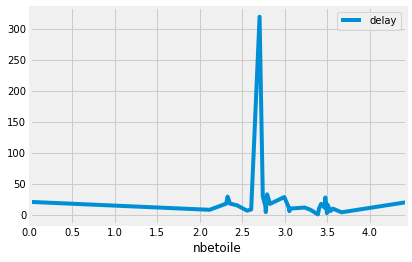

In [247]:
features[['nbetoile','delay']].groupby('nbetoile').mean().plot()

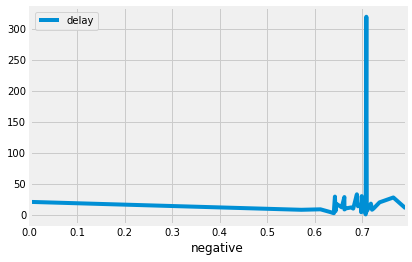

In [248]:
features[['negative','delay']].groupby('negative').mean().plot()

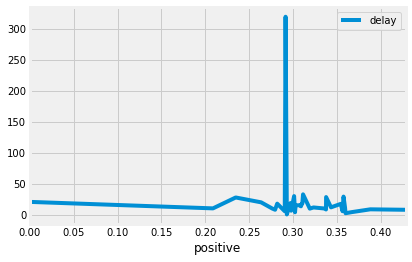

In [249]:
features[['positive','delay']].groupby('positive').mean().plot()

In [ ]:
features[['nbetoile','delay']].groupby('nbetoile').mean().plot()

In [245]:
features[['nbetoile','delay']]

Index(['nbetoile', 'delay'], dtype='object')

In [61]:

import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(plotdf["delay"],plotdf.sort_values(by='nbetoile', ascending=True)["nbetoile"] , s=area, alpha=1)
plt.title('vitesse de vent delay')
plt.xlabel('Delay')
plt.ylabel('vitesse_de_vent')
plt.show()

NameError: name 'plotdf' is not defined

In [62]:
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import numpy as np
threshold = 100 # Anything that occurs less than this will be removed.
value_counts = traindf['delayLabel'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
traindf['delayLabel'].replace(to_remove, np.nan, inplace=True)
traindf=traindf.dropna()

In [109]:

traindf=traindf.drop(['pays'], axis=1)

KeyError: "['pays'] not found in axis"

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
X_train, X_test, y_train, y_test = train_test_split(traindf.drop(['delayLabel','delay'], axis=1), traindf['delayLabel'], test_size=0.33, random_state=0)

In [219]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=False)

In [220]:
params = {
    'bootstrap': [True],
    'n_estimators': [400],
    'max_depth': [20],
    'random_state': [13],
    'max_features': [18]
}


In [156]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [221]:
from imblearn.under_sampling import NearMiss
imba_pipeline = make_pipeline(SMOTE(sampling_strategy='not majority'), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
cross_val_score(imba_pipeline, X_train, y_train, scoring='f1_micro', cv=kf)

array([0.75053396, 0.75010679, 0.74113627, 0.7407091 , 0.75470085])

In [222]:
from sklearn.model_selection import GridSearchCV
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='f1_micro',
                        return_train_score=True)
grid_imba.fit(X_train, y_train);

In [223]:
grid_imba.best_params_

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 18,
 'randomforestclassifier__n_estimators': 400,
 'randomforestclassifier__random_state': 13}

In [224]:
grid_imba.best_score_

0.7412858483298466

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

grid_search = GridSearchCV(estimator=xgbcl, scoring='f1_micro', param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

In [250]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='not majority')

# Fit the y_train to generate the data.
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

grid_search = GridSearchCV(estimator=xgbcl, scoring='f1_micro', param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clr = OneVsRestClassifier(LogisticRegression(max_iter=1500))
clr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1500,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [189]:
import numpy
numpy.mean(clr.predict(X_test).ravel() == y_test.ravel()) * 100

77.36339982653946

In [190]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, clr.predict(X_test)))
try:
    df.columns = [str(_) for _ in clr.classes_][:df.shape[1]]
    df.index = [str(_) for _ in clr.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, clr.classes_)
df

,[0-15],[15-30],[150-210],[210-270],[270-300],[30-45],[45-60],[60-75],[75-90],[90-150],more then 5 hours
[0-15],4460,0,0,0,0,0,0,0,0,0,0
[15-30],470,0,0,0,0,0,1,0,0,0,0
[150-210],38,0,0,0,0,0,2,0,0,0,0
[210-270],9,0,0,0,0,0,0,0,0,0,0
[270-300],2,0,0,0,0,0,0,0,0,0,0
[30-45],239,0,0,0,0,0,0,0,0,0,0
[45-60],182,0,0,0,0,0,0,0,0,0,0
[60-75],115,0,0,0,0,0,0,0,0,0,0
[75-90],78,0,0,0,0,0,0,0,0,0,0
[90-150],155,0,0,0,0,0,0,0,0,0,0


In [191]:
from sklearn.ensemble import RandomForestClassifier
import numpy
rfc = RandomForestClassifier(criterion = 'entropy')
rfc.fit(X_train, y_train)
numpy.mean(rfc.predict(X_test).ravel() == y_test.ravel()) * 100

77.22463139635732

In [192]:
rf_train = clr.decision_function(X_train)

rfc_y = RandomForestClassifier()
rfc_y.fit(rf_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [193]:
rf_test = clr.predict(X_test)
numpy.mean(rf_test == y_test) * 100

77.36339982653946

In [194]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, rf_test))

                   precision    recall  f1-score   support

           [0-15]       0.77      1.00      0.87      4460
          [15-30]       0.00      0.00      0.00       471
        [150-210]       0.00      0.00      0.00        40
        [210-270]       0.00      0.00      0.00         9
        [270-300]       0.00      0.00      0.00         2
          [30-45]       0.00      0.00      0.00       239
          [45-60]       0.00      0.00      0.00       182
          [60-75]       0.00      0.00      0.00       115
          [75-90]       0.00      0.00      0.00        78
         [90-150]       0.00      0.00      0.00       155
more then 5 hours       0.00      0.00      0.00        14

         accuracy                           0.77      5765
        macro avg       0.07      0.09      0.08      5765
     weighted avg       0.60      0.77      0.68      5765



In [181]:
X_train

,aircraft_aircrafttype_icaocode,flightnumbers_icaoflightnumber,airportresources_terminal,airports_destination_name,airlines_airline_name,airlines_operator_icaocode,airlines_airline_icaocode,countrytype_code,pression,direction_de_vent,vitesse_de_vent,temperature,humidité,visibilité,nebulosite,hauteur_neige,confirmed,nbetoile,negative,positive,part_of_day,YEAR(timestamps_sobt),DAY(timestamps_sobt),MONTH(timestamps_sobt),WEEK(timestamps_sobt),WEEKDAY(timestamps_sobt),HOUR(timestamps_sobt),IS_WEEKEND(timestamps_sobt),MINUTE(timestamps_sobt),SECOND(timestamps_sobt),meandelay
id_Flight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12035,4,36,2,22,12,3,3,2,101900.0,330.0,7.2,282.78,46.0,10000.0,6.0,0.0,1219.0,3.231884,0.64058,0.35942,0,2020,9,3,11,0,15,0,55,0,11.661925
16304,5,229,1,77,29,28,26,0,102200.0,0.0,1.0,281.60,57.0,10000.0,5.0,0.0,4496.0,3.425498,0.69004,0.30996,2,2020,14,3,11,5,9,1,30,0,21.164882
4432,5,237,1,24,29,28,26,0,102300.0,190.0,10.8,286.63,50.0,10000.0,32.0,0.0,11.0,3.425498,0.69004,0.30996,0,2020,8,2,6,5,13,1,35,0,21.164882
14092,3,315,2,26,62,56,56,1,102200.0,0.0,1.0,280.39,93.0,4400.0,18.0,0.0,3.0,0.000000,0.00000,0.00000,2,2020,25,1,4,5,11,1,35,0,2.625000
16963,32,54,2,25,12,3,3,2,101600.0,160.0,3.1,281.72,43.0,10000.0,100.0,0.0,57.0,3.231884,0.64058,0.35942,1,2020,28,2,9,4,19,0,55,0,11.661925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,4,33,2,116,12,3,3,2,101800.0,230.0,6.7,287.67,42.0,10000.0,31.0,0.0,11.0,3.231884,0.64058,0.35942,0,2020,10,2,7,0,16,0,10,0,11.661925
13123,5,160,1,88,28,21,20,2,101800.0,150.0,3.1,286.93,56.0,10000.0,96.0,0.0,1136.0,3.425498,0.69004,0.30996,0,2020,8,3,10,6,14,1,50,0,16.987730
9845,4,158,1,31,28,21,20,2,102000.0,160.0,3.1,293.32,33.0,10000.0,2.0,0.0,10970.0,3.425498,0.69004,0.30996,0,2020,19,3,12,3,17,0,5,0,16.987730


In [50]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  

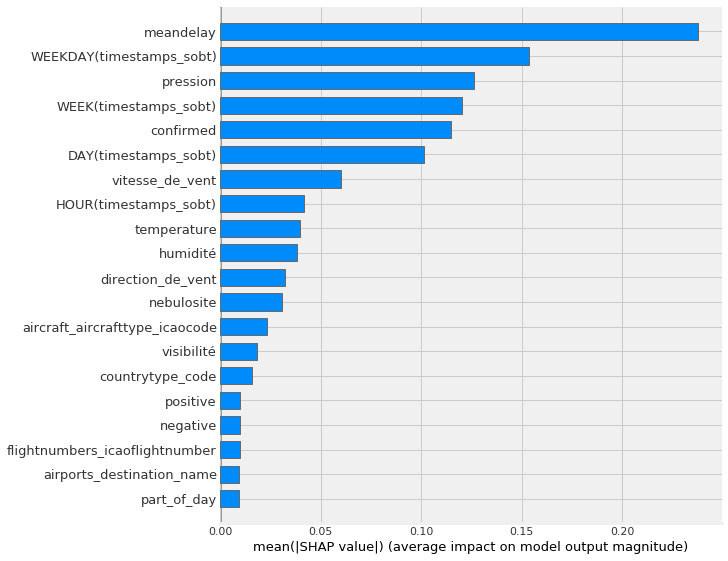

In [203]:
import xgboost
import shap# load JS visualization code to notebook
shap.initjs()# train XGBoost model
y=LabelEncoder().fit_transform(y_train)
model = xgboost.train({"learning_rate": 0.02}, xgboost.DMatrix(X_train, label=y), 100)# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

AttributeError: 'Booster' object has no attribute 'score'

In [209]:
from sklearn.feature_selection import SelectKBest,chi2
test = SelectKBest(score_func=chi2, k=)
fit = test.fit(X, y)
features = fit.transform(X)

SyntaxError: invalid syntax (<ipython-input-209-ffd9b023a541>, line 2)

In [101]:
print(features)

[[3.80e+01 2.00e+00 3.30e+02 1.00e+04]
 [1.53e+02 2.00e+01 1.60e+02 1.00e+04]
 [2.47e+02 4.00e+00 1.30e+02 1.00e+04]
 ...
 [3.18e+02 5.70e+01 1.80e+02 1.00e+04]
 [5.70e+01 2.00e+00 6.00e+01 3.20e+03]
 [1.93e+02 2.00e+01 1.00e+01 1.00e+04]]


In [43]:
def get_models():
    models, names = list(), list()
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    return models, names

In [44]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    return scores

In [ ]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [48]:
from sklearn.model_selection import RepeatedStratifiedKFold
models=get_models()
evaluate_model(X_train, y_train, models[0])

TypeError: estimator should be an estimator implementing 'fit' method, [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)] was passed

In [214]:
clf = RandomForestClassifier(max_depth=30, random_state=0,criterion = 'entropy',bootstrap= True,
    n_estimators=200,max_features=6)
clf.fit(X_train, y_train)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 42314)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=30, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [215]:
print(clf.feature_importances_)

[0.04509331 0.07029152 0.00518184 0.06396519 0.01725821 0.01652586
 0.01630545 0.0191851  0.05729891 0.05917907 0.06163056 0.0777276
 0.06176983 0.01231339 0.04921234 0.         0.04125202 0.01502818
 0.01667611 0.01874116 0.01712639 0.         0.04597343 0.00800914
 0.02704804 0.03415039 0.05015552 0.00674621 0.05466924 0.
 0.03148599]


In [216]:
ypred=clf.predict(X_test)

In [217]:
print(classification_report(y_test, ypred))


                   precision    recall  f1-score   support

           [0-15]       0.86      0.94      0.90      4460
          [15-30]       0.23      0.16      0.19       471
        [150-210]       0.58      0.38      0.45        40
        [210-270]       0.25      0.22      0.24         9
        [270-300]       0.00      0.00      0.00         2
          [30-45]       0.30      0.23      0.26       239
          [45-60]       0.27      0.21      0.23       182
          [60-75]       0.26      0.19      0.22       115
          [75-90]       0.29      0.22      0.25        78
         [90-150]       0.71      0.45      0.55       155
more then 5 hours       1.00      0.43      0.60        14

         accuracy                           0.78      5765
        macro avg       0.43      0.31      0.35      5765
     weighted avg       0.74      0.78      0.76      5765



In [218]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
try:
    df.columns = [str(_) for _ in clf.classes_][:df.shape[1]]
    df.index = [str(_) for _ in clf.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, clr.classes_)
df

,[0-15],[15-30],[150-210],[210-270],[270-300],[30-45],[45-60],[60-75],[75-90],[90-150],more then 5 hours
[0-15],4173,185,0,0,0,54,26,11,5,6,0
[15-30],355,74,0,0,0,28,8,6,0,0,0
[150-210],10,0,15,5,0,0,0,0,4,6,0
[210-270],4,0,1,2,2,0,0,0,0,0,0
[270-300],0,0,1,1,0,0,0,0,0,0,0
[30-45],104,34,0,0,0,54,35,6,5,1,0
[45-60],69,20,0,0,0,27,38,20,6,2,0
[60-75],39,2,0,0,0,13,20,22,12,7,0
[75-90],32,2,0,0,0,1,7,13,17,6,0
[90-150],48,0,9,0,0,4,7,8,10,69,0


In [168]:
model.score(X_test,y_test)

AttributeError: 'Booster' object has no attribute 'score'

In [251]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [252]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [253]:
model = XGBClassifier(colsample_bytree=1,learning_rate=0.5,max_depth=2,subsample=1,n_estimators=400)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [254]:

# make predictions for test data
y_pred2 = model.predict(X_test)

In [255]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.89%


In [256]:
print(classification_report(y_test, y_pred2))

                   precision    recall  f1-score   support

           [0-15]       0.86      0.89      0.87      4460
          [15-30]       0.19      0.12      0.15       471
        [150-210]       0.30      0.35      0.33        40
        [210-270]       0.17      0.11      0.13         9
        [270-300]       0.00      0.00      0.00         2
          [30-45]       0.16      0.11      0.13       239
          [45-60]       0.17      0.20      0.19       182
          [60-75]       0.17      0.20      0.18       115
          [75-90]       0.15      0.15      0.15        78
         [90-150]       0.29      0.38      0.33       155
more then 5 hours       0.75      0.43      0.55        14

         accuracy                           0.73      5765
        macro avg       0.29      0.27      0.27      5765
     weighted avg       0.71      0.73      0.72      5765



In [269]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=15)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

In [284]:
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)

ValueError: Input X must be non-negative.

In [285]:
clf = RandomForestClassifier(max_depth=10, random_state=42,criterion = 'entropy',bootstrap= True,
    n_estimators=400,min_samples_split=50,n_jobs=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [286]:
clf.score(X_test,y_test)

0.7643511818620357

In [230]:
from sklearn.preprocessing import OrdinalEncoder
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    oe.fit(X_test)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [231]:
X_train, X_test = prepare_inputs(X_train, X_test)
# prepare output data
y_train, y_test = prepare_targets(y_train, y_test)

In [232]:
X_train

array([[  5.,  96.,   1., ...,   0.,   0.,   0.],
       [ 26.,  26.,   2., ...,   0.,   1.,   0.],
       [ 18., 245.,   1., ...,   1.,   8.,   0.],
       ...,
       [ 27., 137.,   1., ...,   0.,   1.,   0.],
       [ 31.,  59.,   2., ...,   0.,   9.,   0.],
       [ 30.,  13.,   2., ...,   0.,   3.,   0.]])

In [298]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
rfc_cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall_micro')

In [299]:
rfc_cv_score

array([0.7664791 , 0.76688103, 0.76678729, 0.76678729, 0.7663852 ,
       0.7664791 , 0.76688103, 0.76678729, 0.76678729, 0.7663852 ,
       0.7664791 , 0.7664791 , 0.76678729, 0.76678729, 0.7663852 ])

In [51]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [155]:
param = {}
param['booster'] = 'gbtree'
param['objective'] = "multi:softprob"
param["eval_metric"] = "merror"
param['eta'] = 0.3
param['num_class'] = 11
param['gamma'] = 0
param['scale_pos_weight']=100
param['max_depth'] = 10
param['min_child_weight']=1
param['max_delta_step'] = 5
param['subsample']= 1
param['colsample_bytree']=1
param['silent'] = 1
param['seed'] = 0
param['base_score'] = 0.5
param['early_stopping_rounds'] = 15
param['learning_rate'] = 0.8
param['n_estimators'] = 100
import xgboost as xgb
clf = xgb.XGBClassifier(param)

In [156]:
boost = xgb.XGBClassifier(param)
boost.fit(X_train, y_train)
p_boost = boost.predict(X_train)
print ("Score Train -->", round(boost.score(X_test, y_test) *100,2), " %")


Score Train --> 78.52  %


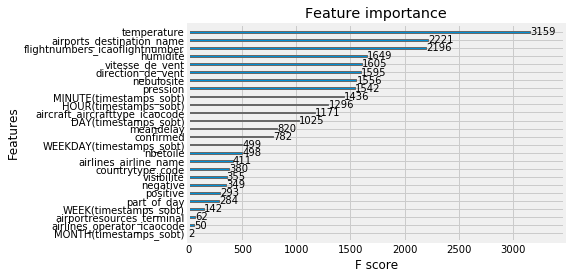

In [145]:
xgb.plot_importance(boost)

In [146]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, boost.predict(X_test)))
try:
    df.columns = [str(_) for _ in boost.classes_][:df.shape[1]]
    df.index = [str(_) for _ in boost.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, boost.classes_)
df

,[0-15],[15-30],[150-210],[210-270],[270-300],[30-45],[45-60],[60-75],[75-90],[90-150],more then 5 hours
[0-15],4287,96,0,0,0,39,13,5,4,3,0
[15-30],383,39,0,0,0,26,8,6,0,0,0
[150-210],6,2,13,5,2,2,0,1,1,4,0
[210-270],5,0,1,3,3,0,0,0,1,0,0
[270-300],0,0,0,1,1,0,0,0,0,0,0
[30-45],160,23,0,0,0,37,27,17,2,2,0
[45-60],97,12,0,0,0,23,32,24,4,1,0
[60-75],37,4,0,0,0,11,19,30,5,4,0
[75-90],37,1,0,0,0,0,2,18,20,7,0
[90-150],46,0,7,0,0,3,7,10,6,62,0


In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_test, boost.predict(X_test)))

                   precision    recall  f1-score   support

           [0-15]       0.85      0.96      0.90      4447
          [15-30]       0.22      0.08      0.12       462
        [150-210]       0.62      0.36      0.46        36
        [210-270]       0.33      0.23      0.27        13
        [270-300]       0.12      0.50      0.20         2
          [30-45]       0.26      0.14      0.18       268
          [45-60]       0.30      0.17      0.21       193
          [60-75]       0.27      0.27      0.27       110
          [75-90]       0.47      0.24      0.31        85
         [90-150]       0.75      0.44      0.55       141
more then 5 hours       1.00      0.45      0.62        11

         accuracy                           0.79      5768
        macro avg       0.47      0.35      0.37      5768
     weighted avg       0.73      0.79      0.75      5768



NameError: name 'y_smt' is not defined

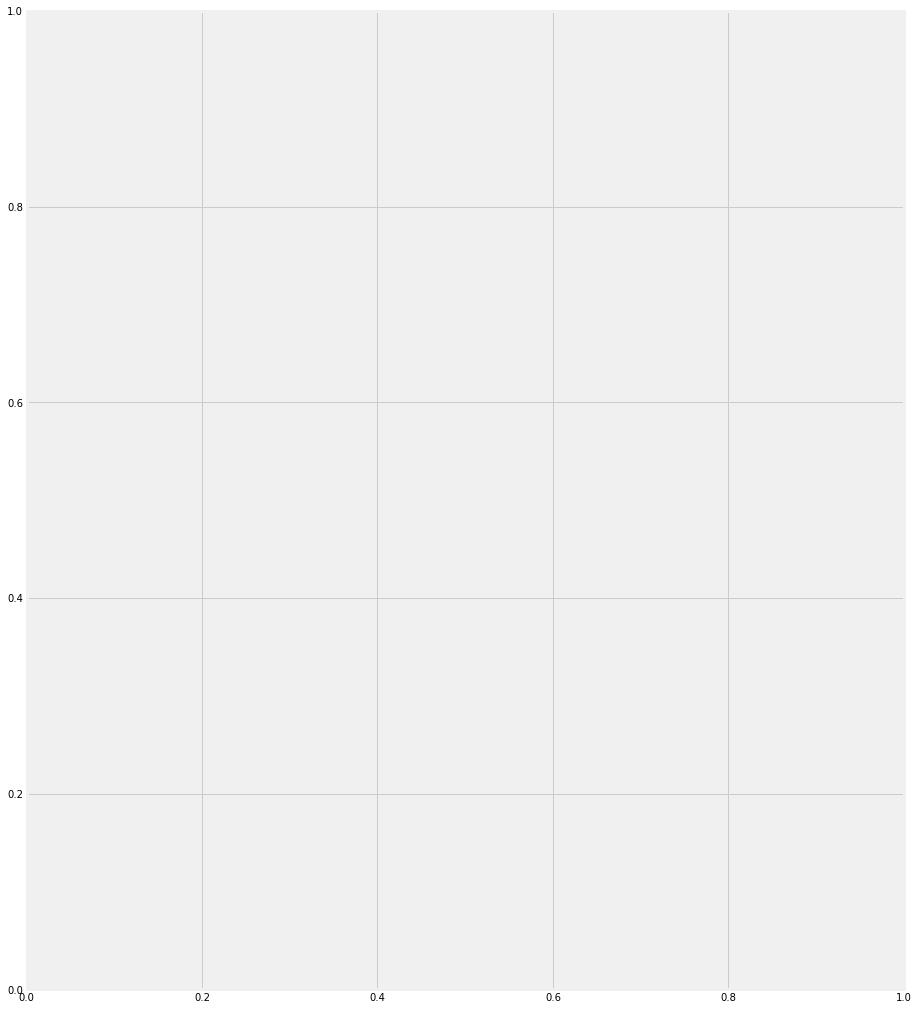

In [108]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


fig_dim=(14,18)
f,ax=plt.subplots(figsize=fig_dim)
quality=y_smt.unique()
size=y_smt.value_counts()
plt.pie(size,labels=quality,autopct="%1.0f%%")
plt.show() 

In [71]:
import lightgbm as lgb

In [ ]:
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier(objective='multiclass', random_state=5,categorical_feature= 'auto',feature_name='auto')

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

In [ ]:
lgbm.score(X_test,y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, lgbm.predict(X_test)))
try:
    df.columns = [str(_) for _ in lgbm.classes_][:df.shape[1]]
    df.index = [str(_) for _ in lgbm.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, lgbm.classes_)
df

In [141]:
from xgboost import XGBClassifier

# manually handling imbalance. Below is same as computing float(18501)/392318 on the trainig dataset.
# We are going to inversely assign the weights
newlist=set(y_train)
newlist.remove('[0-15]')
total=0
w_array = np.array([1]*y_train.shape[0])
for classes in newlist:
    
    weight_ratio = float(len(y_train[y_train == '[0-15]']))/float(len(y_train[y_train == 
    classes]))
    w_array[y_train==classes] = weight_ratio
w_array[y_train=='[0-15]'] = 1
xgc = XGBClassifier({"learning_rate": 0.5,'num_class':11}, xgboost.DMatrix(X_train, label=y), 100)
xgc.fit(X_train, y_train, sample_weight=w_array) 


NameError: name 'xgboost' is not defined

In [196]:
w_array

array([1, 1, 1, ..., 1, 1, 1])

In [197]:
set(y_train)

{'[0-15]',
 '[15-30]',
 '[150-210]',
 '[210-270]',
 '[270-300]',
 '[30-45]',
 '[45-60]',
 '[60-75]',
 '[75-90]',
 '[90-150]',
 'more then 5 hours'}

In [198]:
print ("Score Train -->", round(xgc.score(X_test, y_test) *100,2), " %")

Score Train --> 68.59  %


In [199]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, xgc.predict(X_test)))
try:
    df.columns = [str(_) for _ in xgc.classes_][:df.shape[1]]
    df.index = [str(_) for _ in xgc.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, xgc.classes_)
df

,[0-15],[15-30],[150-210],[210-270],[270-300],[30-45],[45-60],[60-75],[75-90],[90-150],more then 5 hours
[0-15],3558,536,8,0,0,173,101,34,19,30,1
[15-30],211,143,1,0,0,68,27,10,6,5,0
[150-210],2,4,17,5,0,0,1,2,2,7,0
[210-270],3,0,1,2,3,0,0,0,0,0,0
[270-300],0,0,1,1,0,0,0,0,0,0,0
[30-45],49,52,0,0,0,66,46,13,10,3,0
[45-60],29,35,1,1,1,29,42,29,9,6,0
[60-75],15,11,1,0,0,19,21,26,15,7,0
[75-90],7,12,0,0,0,0,14,13,24,8,0
[90-150],21,7,10,0,0,8,12,10,16,71,0


In [200]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgc.predict(X_test)))

                   precision    recall  f1-score   support

           [0-15]       0.91      0.80      0.85      4460
          [15-30]       0.18      0.30      0.23       471
        [150-210]       0.41      0.42      0.42        40
        [210-270]       0.22      0.22      0.22         9
        [270-300]       0.00      0.00      0.00         2
          [30-45]       0.18      0.28      0.22       239
          [45-60]       0.16      0.23      0.19       182
          [60-75]       0.19      0.23      0.21       115
          [75-90]       0.24      0.31      0.27        78
         [90-150]       0.51      0.46      0.48       155
more then 5 hours       0.83      0.36      0.50        14

         accuracy                           0.69      5765
        macro avg       0.35      0.33      0.33      5765
     weighted avg       0.76      0.69      0.72      5765



In [201]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgc.predict(X_train)))

                   precision    recall  f1-score   support

           [0-15]       1.00      0.84      0.91      9104
          [15-30]       0.48      0.87      0.62       959
        [150-210]       0.86      0.96      0.91        70
        [210-270]       0.83      1.00      0.91        20
        [270-300]       0.70      0.88      0.78         8
          [30-45]       0.53      0.81      0.64       519
          [45-60]       0.57      0.85      0.68       364
          [60-75]       0.58      0.89      0.70       232
          [75-90]       0.64      0.96      0.77       146
         [90-150]       0.80      0.89      0.85       262
more then 5 hours       0.94      0.85      0.89        20

         accuracy                           0.84     11704
        macro avg       0.72      0.89      0.79     11704
     weighted avg       0.90      0.84      0.86     11704



In [202]:
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]

NameError: name 'class_weights' is not defined

In [69]:
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

NameError: name 'CreateBalancedSampleWeights' is not defined

In [70]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [142]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
clf = OneVsRestClassifier(XGBClassifier(max_depth=5,learning_rate=0.5))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.
mlb = MultiLabelBinarizer()
y_train1 = mlb.fit_transform(y_train.str.split(","))

clf.fit(X_train, y_train1)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.5,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            rand

In [115]:
mlb.classes_

array(['[0-15]', '[15-30]', '[150-210]', '[210-270]', '[270-300]',
       '[30-45]', '[45-60]', '[60-75]', '[75-90]', '[90-150]',
       'more then 5 hours'], dtype=object)

In [69]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
try:
    df.columns = [str(_) for _ in clf.classes_][:df.shape[1]]
    df.index = [str(_) for _ in clf.classes_][:df.shape[0]]
except ValueError:
    # Il peut arriver qu'une classe ne soit pas représenter
    # lors de l'apprentissage
    print("erreur", df.shape, clf.classes_)
df

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [136]:
from sklearn.metrics import classification_report

y_test1 = mlb.fit_transform(y_test.str.split(","))
print(classification_report(y_test1, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4447
           1       0.23      0.15      0.18       462
           2       0.62      0.36      0.46        36
           3       0.38      0.23      0.29        13
           4       0.20      0.50      0.29         2
           5       0.22      0.11      0.15       268
           6       0.35      0.20      0.25       193
           7       0.26      0.17      0.21       110
           8       0.44      0.21      0.29        85
           9       0.76      0.41      0.53       141
          10       1.00      0.45      0.62        11

   micro avg       0.80      0.75      0.78      5768
   macro avg       0.49      0.34      0.38      5768
weighted avg       0.76      0.75      0.75      5768
 samples avg       0.75      0.75      0.75      5768



In [140]:
mlb.inverse_transform(clf.predict(X_test))

[('[0-15]',),
 (),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[45-60]',),
 ('[15-30]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 (),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[15-30]',),
 ('[15-30]',),
 ('[15-30]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 (),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[60-75]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 (),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[15-30]',),
 ('[60-75]',),
 ('[0-15]',),
 ('[15-30]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[90-150]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[15-30]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 ('[0-15]',),
 (

In [87]:
y_test

id_Flight
14946      [0-15]
11434    [90-150]
1310      [15-30]
6647       [0-15]
14916      [0-15]
           ...   
4544       [0-15]
6232       [0-15]
2369      [15-30]
10374    [90-150]
14212      [0-15]
Name: delayLabel, Length: 5768, dtype: category
Categories (11, object): [[0-15], [15-30], [150-210], [210-270], ..., [60-75], [75-90], [90-150], more then 5 hours]

In [79]:
X_train

,aircraft_aircrafttype_icaocode,flightnumbers_icaoflightnumber,airportresources_terminal,airports_destination_name,airlines_airline_name,airlines_operator_icaocode,airlines_airline_icaocode,countrytype_code,pression,direction_de_vent,vitesse_de_vent,temperature,humidité,visibilité,nebulosite,hauteur_neige,confirmed,nbetoile,negative,positive,part_of_day,YEAR(timestamps_sobt),DAY(timestamps_sobt),MONTH(timestamps_sobt),WEEK(timestamps_sobt),WEEKDAY(timestamps_sobt),HOUR(timestamps_sobt),IS_WEEKEND(timestamps_sobt),MINUTE(timestamps_sobt),SECOND(timestamps_sobt),meandelay
id_Flight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6820,30,8,2,22,12,3,3,2,102400.0,0.0,0.5,284.27,81.0,10000.0,90.0,0.0,2293.0,3.231884,0.64058,0.35942,2,2020,11,3,11,2,8,0,25,0,11.661925
1662,28,19,2,62,12,3,3,2,101000.0,310.0,3.1,279.20,70.0,10000.0,90.0,0.0,656.0,3.231884,0.64058,0.35942,1,2020,6,3,10,4,19,0,55,0,11.661925
11618,32,12,2,80,12,3,3,2,102200.0,30.0,1.0,278.79,81.0,7000.0,100.0,0.0,2.0,3.231884,0.64058,0.35942,0,2020,24,1,4,4,16,0,5,0,11.661925
14416,5,174,1,11,28,21,20,3,101500.0,180.0,6.2,285.11,54.0,10000.0,20.0,0.0,4532.0,3.425498,0.69004,0.30996,1,2020,15,3,11,6,19,1,30,0,16.987730
16443,4,242,1,66,29,28,26,0,102000.0,350.0,5.1,285.58,43.0,10000.0,24.0,0.0,4496.0,3.425498,0.69004,0.30996,0,2020,14,3,11,5,16,1,25,0,21.164882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,4,33,2,116,12,3,3,2,101800.0,230.0,6.7,287.67,42.0,10000.0,31.0,0.0,11.0,3.231884,0.64058,0.35942,0,2020,10,2,7,0,16,0,10,0,11.661925
13123,5,188,1,121,28,21,20,2,101800.0,0.0,1.0,286.82,41.0,10000.0,96.0,0.0,1136.0,3.425498,0.69004,0.30996,0,2020,8,3,10,6,14,1,0,0,16.987730
9845,4,158,1,31,28,21,20,2,102000.0,160.0,3.1,293.32,33.0,10000.0,2.0,0.0,10970.0,3.425498,0.69004,0.30996,0,2020,19,3,12,3,17,0,5,0,16.987730
